In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TOKENIZERS_PARALLELISM"]="true"
import calendar

import pandas as pd
import numpy as np 
# import gensim
import nltk
import spacy
import re
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS
from functools import reduce
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from tqdm import tqdm
# from torchtext.data.utils import get_tokenizer
# from torchtext.vocab import build_vocab_from_iterator
from copy import deepcopy

%matplotlib inline

# Agenda

1. [Data Preparation + Data Exploration (in a short)](#Data_Preparation_Data_Exploration)
2. [Logistic and Linear (only theory) Regressions](#Logistic_and_Linear_Regressions)
3. [Reccurent Neural Networks (RNN, GRU, LSTM)](#Reccurent_Neural_Networks)
4. [Sentance and Token (only theory) Classification](#Sentance_and_Token_Classification) 
5. [Homework](#Homework)

# Resources
- https://scikit-learn.org/stable/modules/linear_model.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- https://github.com/udsclub/udscourse
- https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data
- https://en.wikipedia.org
- https://eli5.readthedocs.io/en/latest/overview.html
- https://www.kaggle.com/code/kanncaa1/deep-learning-tutorial-for-beginners
- https://www.kaggle.com/code/thebrownviking20/intro-to-recurrent-neural-networks-lstm-gru
- https://pytorch.org/docs/stable/index.html
- https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
- https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html
- https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
- https://pytorch.org/docs/stable/data.html
- https://pytorch.org/docs/stable/nn.html#loss-functions
- https://pytorch.org/docs/stable/optim.html
- https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
- https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
- https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/

<a id='Data_Preparation_Data_Exploration'></a>
# Data Preparation + Data Exploration

## Load 

In [3]:
os.listdir("../data/jigsaw-toxic-comment-classification-challenge/")

['.DS_Store',
 'test_labels.csv',
 'test.csv',
 'train.csv',
 'sample_submission.csv.zip']

In [4]:
train = pd.read_csv("../data/jigsaw-toxic-comment-classification-challenge/train.csv")
test = pd.read_csv("../data/jigsaw-toxic-comment-classification-challenge/test.csv")
test_labels = pd.read_csv("../data/jigsaw-toxic-comment-classification-challenge/test_labels.csv")

## Initial Exploration

#### TODO: Explain difference between multiclass and multilabel. Can task be multiclass and multilabel at the same time ? 

Answer: In multi-class classification, each input will have only one output class, but in multi-label classification, each input can have multi-output classes.

In [5]:
TARGET_COLUMNS = [
    "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"
]

In [6]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
# test_labels.csv - labels for the test data; value of -1 indicates it was not used for scoring; (Note: file added after competition close!)
# From https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data

test_labels.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [8]:
train.shape, test.shape

((159571, 8), (153164, 2))

## Merge tables

In [13]:
test = test.merge(test_labels, on="id")
test = test[~(test[TARGET_COLUMNS] == -1).any(axis=1)].reset_index(drop=True)

In [14]:
test.head()

,id,comment_text,toxic_x,severe_toxic_x,obscene_x,threat_x,insult_x,identity_hate_x,toxic_y,severe_toxic_y,obscene_y,threat_y,insult_y,identity_hate_y,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
test.shape

(63978, 20)

## Explore Columns

In [16]:
train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [17]:
test.isnull().sum()

id                 0
comment_text       0
toxic_x            0
severe_toxic_x     0
obscene_x          0
threat_x           0
insult_x           0
identity_hate_x    0
toxic_y            0
severe_toxic_y     0
obscene_y          0
threat_y           0
insult_y           0
identity_hate_y    0
toxic              0
severe_toxic       0
obscene            0
threat             0
insult             0
identity_hate      0
dtype: int64

In [18]:
print("Train")
for tgt_col in TARGET_COLUMNS:
    print(train[tgt_col].value_counts(normalize=True))

Train
0    0.904156
1    0.095844
Name: toxic, dtype: float64
0    0.990004
1    0.009996
Name: severe_toxic, dtype: float64
0    0.947052
1    0.052948
Name: obscene, dtype: float64
0    0.997004
1    0.002996
Name: threat, dtype: float64
0    0.950636
1    0.049364
Name: insult, dtype: float64
0    0.991195
1    0.008805
Name: identity_hate, dtype: float64


In [19]:
print("Test")
for tgt_col in TARGET_COLUMNS:
    print(test[tgt_col].value_counts(normalize=True))

Test
0    0.904811
1    0.095189
Name: toxic, dtype: float64
0    0.994264
1    0.005736
Name: severe_toxic, dtype: float64
0    0.942308
1    0.057692
Name: obscene, dtype: float64
0    0.996702
1    0.003298
Name: threat, dtype: float64
0    0.946435
1    0.053565
Name: insult, dtype: float64
0    0.988871
1    0.011129
Name: identity_hate, dtype: float64


## Text Preparation

In [20]:
nltk.download('punkt')
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
def preprocess(text, join_back=True):
    result = []
    sentences = nltk.sent_tokenize(text)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        result.extend(filtered_words)
    if join_back:
        result = " ".join(result)
    return result

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tarasbohdan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
idx = 100

print(
    f"Before : {train['comment_text'].iloc[idx]}\n"
    f"After : {preprocess(train['comment_text'].iloc[idx])}"
)

Before : However, the Moonlite edit noted by golden daph was me (on optus ...)  Wake up wikkis.  So funny
After : however moonlite edit noted golden daph optus wake wikkis funny


In [22]:
train['hard_clean_comment_text'] = train['comment_text'].apply(preprocess)
test['hard_clean_comment_text'] = test['comment_text'].apply(preprocess)

## Text Visualisation

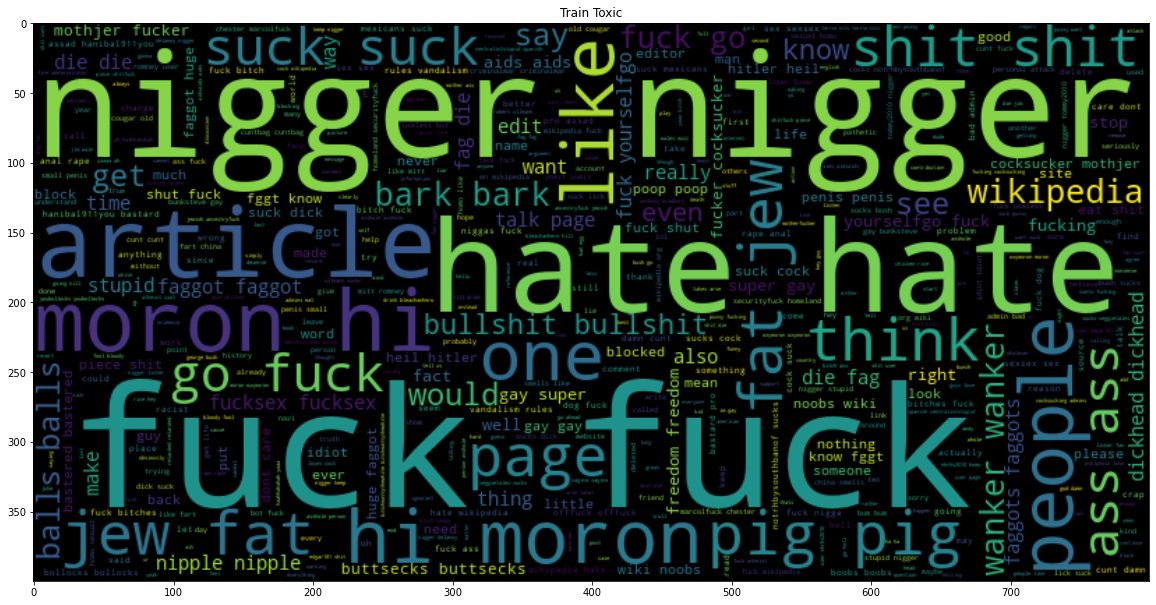

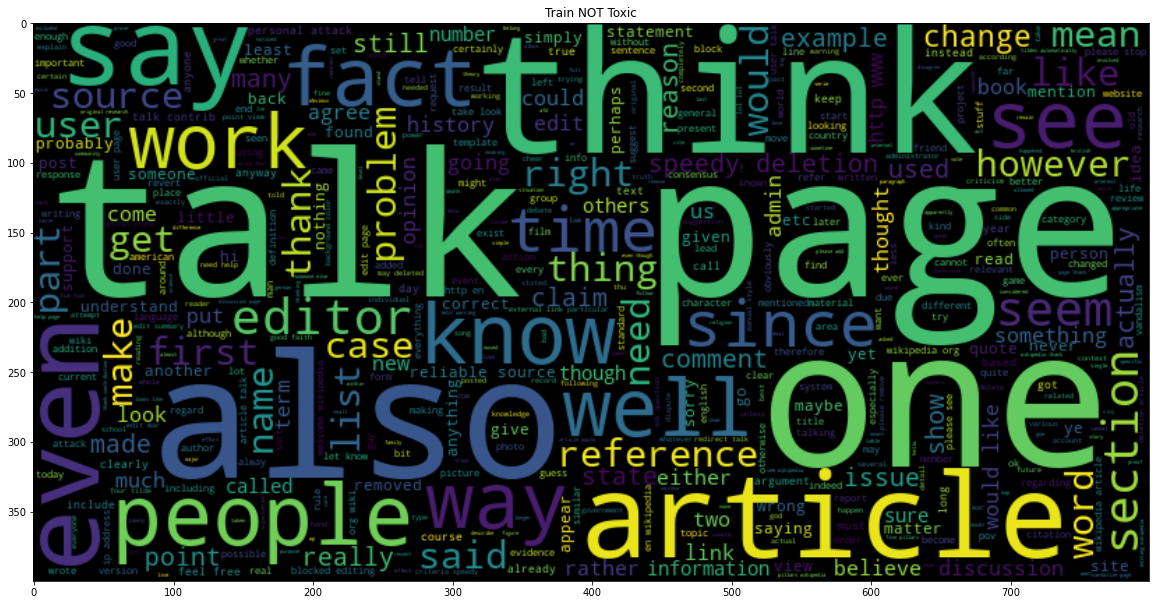

In [21]:
plt.figure(figsize = (20,20)) 
plt.title("Train Toxic")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(train.loc[train["toxic"] == 1, 'hard_clean_comment_text']))
plt.imshow(wc, interpolation = 'bilinear')

plt.figure(figsize = (20,20)) 
plt.title("Train NOT Toxic")
wc = WordCloud(max_words = 500 , width = 800 , height = 400 , stopwords = stop_words).generate(" ".join(train.loc[train["toxic"] == 0, 'hard_clean_comment_text']))
plt.imshow(wc, interpolation = 'bilinear')

<a id='Logistic_and_Linear_Regressions'></a>
# [Logistic](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) and [Linear](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) Regressions

Consider limited space of linear functions with $\large \left(m + 1\right)$ parameters, where one of the parameter refers to bias ($\large x_0 = 1$):

$$\large \begin{array}{rcl} \forall h \in \mathcal{H}, h\left(\vec{x}\right) &=& w_0 x_0 + w_1 x_1 + w_2 x_2 + \cdots + w_m x_m \\
&=& \sum_{i=0}^m w_i x_i \\
&=& \vec{x}^T \vec{w}
\end{array}$$
where:
* $\large \vec{x} \in \mathbb{R}^{m + 1}$

In such a case [Empirical risk](https://en.wikipedia.org/wiki/Empirical_risk_minimization) is equal to [MSE](https://en.wikipedia.org/wiki/Mean_squared_error) (Mean Squared Error)
$$\large \begin{array}{rcl}\mathcal{L}\left(X, \vec{y}, \vec{w} \right) &=& \frac{1}{2n} \sum_{i=1}^n \left(y_i - \vec{x}_i^T \vec{w}_i\right)^2 \\
&=& \frac{1}{2n} \left\| \vec{y} - X \vec{w} \right\|_2^2 \\
&=& \frac{1}{2n} \left(\vec{y} - X \vec{w}\right)^T \left(\vec{y} - X \vec{w}\right)
\end{array}$$
where:
* $\large \vec{w} \in \mathbb{R}^{m + 1}$
* $\large \vec{y} \in \mathbb{R}^n$
* $\large X$ is $\large n \times m + 1$ matrix, where each row is a feature vector.

Lets find out optimization algorithm. Considering that fact that cost function is convex, we can find point of global minimum:
$$\large \begin{array}{rcl} \frac{\partial \mathcal{L}}{\partial \vec{w}} &=& \frac{\partial}{\partial \vec{w}} \frac{1}{2n} \left( \vec{y}^T \vec{y} -2\vec{y}^T X \vec{w} + \vec{w}^T X^T X \vec{w}\right) \\
&=& \frac{1}{2n} \left(-2 X^T \vec{y} + 2X^T X \vec{w}\right)
\end{array}$$

This method is called [Least Squares](https://en.wikipedia.org/wiki/Least_squares) method:
$$\large \begin{array}{rcl} \frac{\partial \mathcal{L}}{\partial \vec{w}} = 0 &\Leftrightarrow& \frac{1}{2n} \left(-2 X^T \vec{y} + 2X^T X \vec{w}\right) = 0 \\
&\Leftrightarrow& -X^T \vec{y} + X^T X \vec{w} = 0 \\
&\Leftrightarrow& X^T X \vec{w} = X^T \vec{y} \\
&\Leftrightarrow& \vec{w} = \left(X^T X\right)^{-1} X^T \vec{y}
\end{array}$$

Another way to come up to the same soulition is <a href="https://en.wikipedia.org/wiki/Gauss%E2%80%93Markov_theorem">Gauss–Markov theorem</a>. Also it contains a bunch of interesting properties

TODO: Read about:
- Polinimial Regression 
- Feature Correlation Problem 
- Regularization (L1, L2)
- Feature Scaling, especially Standarization 

Consider [Binary Classification](https://en.wikipedia.org/wiki/Binary_classification) task. Using [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) we can get class probabilities, given some features (lets consider only one feature):

$$\large \begin{array}{rcl} p\left(c = 0 \mid x \right) &=& \frac{p\left(x \mid c = 0\right) p\left(c = 0\right)}{p\left(x \mid c = 0\right) p\left(c = 0\right) + p\left(x \mid c = 1\right) p\left(c = 1\right)} \\
&=& \frac{1}{1 + e^{-a}} = \sigma\left(a\right)
\end{array}$$

where:
$$\large a = \ln \frac{p\left(x \mid c = 0\right) p\left(c = 0\right)}{p\left(x \mid c = 1\right) p\left(c = 1\right)}$$

Assuming that all features are distributed [Normally](https://en.wikipedia.org/wiki/Normal_distribution) with own Mean and Std:
$$\large p\left( x \mid c = k \right) \sim \mathcal{N}\left( \mu_k, \sigma \right)$$

Assuming that classes probability are the same:
$$\large \begin{array}{rcl} a &=& \ln \frac{p\left(x \mid c = 0\right)}{p\left(x \mid c = 1\right)} \\
&=& \ln p\left(x \mid c = 0\right) - \ln p\left(x \mid c = 1\right)\\
&=& \frac{1}{2\sigma^2} \left(\mu_1 - x\right)^2 -\frac{1}{2\sigma^2} \left(\mu_0 - x\right)^2 \\
&=& \frac{1}{2\sigma^2} \left(\left(\mu_1 - x\right)^2 - \left(\mu_0 - x\right)^2\right) \\
&=& \frac{1}{2\sigma^2} \left(\mu_1^2 - 2\mu_1 x + x^2 - \mu_0^2 + 2 \mu_0 x - x^2\right) \\
&=& \frac{\mu_1^2 - \mu_0^2}{2\sigma^2} + \frac{\mu_0 - 2\mu_1}{\sigma^2}x \\
&=& w_0 + w_1 x\\
\end{array}$$

As a result, [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) from [linear combination](https://en.wikipedia.org/wiki/Linear_combination) of features with some parameters is class probability, given some features (assuming that features are Normally distributed).

*Logistic regression* - is a model, where parameters of linear function $\large \vec{w}$ are optimized directly.

Lets find out optimization algorithm for Logistic Regression 

$$\large \frac{\partial \sigma\left(x\right)}{\partial x} = \sigma\left(x\right) \left(1 - \sigma\left(x\right)\right)$$

Considering [Bernoulli distribution](https://en.wikipedia.org/wiki/Bernoulli_distribution) - which is a distribution of [random variable](https://en.wikipedia.org/wiki/Random_variable), which can be $1$ with probability $\large p$ or $0$ with ptobability $\large q = 1 - p$:
$$\large p\left(k \mid p\right) = p^k \left(1 - p\right)^{1 - k}$$

Consider [Likelihood function](https://en.wikipedia.org/wiki/Likelihood_function)

$$\large \begin{array}{rcl}\mathcal{L} &=& \ln p^n \left(1 - p\right)^m \\
\frac{\partial \mathcal{L}}{\partial p} &=& \frac{n}{p} - \frac{m}{1 - p} \\
\frac{\partial \mathcal{L}}{\partial p} = 0 &\Leftrightarrow& \frac{n}{p} = \frac{m}{1 - p} \\
&\Leftrightarrow& p = \frac{n}{n + m}
\end{array}$$

Now lets consider dataset - $\large D = \left\{\left(\vec{x}_i, y_i\right)\right\}_{i=1,\ldots,n}$, $\large \forall i, y_i \in \left\{0, 1\right\}$, than Likelihood function for a particular dataset:

$$\large \begin{array}{rcl}\mathcal{L} &=& \ln \prod_{i=1}^n p\left(c = 0 \mid \vec{x}_i \right)^{y_i} \left(1 - p\left(c = 0 \mid \vec{x}_i \right)\right)^{1 - y_i} \\
&=& \ln \prod_{i=1}^n \sigma\left(\vec{w}^T \vec{x}_i\right)^{y_i} \left(1 - \sigma\left(\vec{w}^T \vec{x}_i\right)\right)^{1 - y_i} \\
&=& \sum_{i=1}^n y_i \ln \sigma\left(\vec{w}^T \vec{x}_i\right) + \left(1 - y_i\right) \ln \left(1 - \sigma\left(\vec{w}^T \vec{x}_i\right)\right)
\end{array}$$

Lets find formula for weights' update for [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent):
$$\large \begin{array}{rcl} \frac{\partial \mathcal{L}}{\partial \vec{w}} &=& \frac{\partial}{\partial \vec{w}}\sum_{i=1}^n y_i \ln \sigma\left(\vec{w}^T \vec{x}_i\right) + \left(1 - y_i\right) \ln \left(1 - \sigma\left(\vec{w}^T \vec{x}_i\right)\right) \\
&=& \sum_{i=1}^n y_i \frac{1}{\sigma} \sigma \left(1 - \sigma\right) \vec{x}_i + \left(1 - y_i\right) \frac{1}{1 - \sigma} \left(-1\right)\sigma \left(1 - \sigma\right) \vec{x}_i \\
&=& \sum_{i=1}^n y_i \left(1 - \sigma\right) \vec{x}_i - \left(1 - y_i\right) \sigma \vec{x}_i \\
&=& \sum_{i=1}^n \vec{x}_i \left(y_i - \sigma\right)
\end{array}$$

## Prepare Validation

In [23]:
# TODO: Understand what I am doing here :)
# TODO: Try to find better solutions for Multilabel stratification
train["strat_feature"] = train[TARGET_COLUMNS].apply(
    lambda x: reduce(lambda x, y: str(x) + str(y), x), axis=1
)
small_strat_groups = train["strat_feature"].value_counts()[
    # Why do I have 5 here ? 
    train["strat_feature"].value_counts() < 5
].index
train.loc[train["strat_feature"].isin(small_strat_groups), "strat_feature"] = "-1"
train["strat_feature"].value_counts()

000000    143346
100000      5666
101010      3800
101000      1758
100010      1215
111010       989
101011       618
001000       317
000010       301
111011       265
001010       181
111000       158
100001       136
100011       134
101110       131
100100       113
111110        64
101111        56
000001        54
110000        41
101001        35
111111        31
000011        28
-1            22
000100        22
001011        18
100110        16
110010        14
101100        11
110100        11
110011         7
100101         7
111001         6
Name: strat_feature, dtype: int64

In [24]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
folds_train_test_ids = [el for el in skf.split(train, train["strat_feature"])]

In [25]:
X_train_fold_0, X_test_fold_0 = train.iloc[folds_train_test_ids[0][0]], train.iloc[folds_train_test_ids[0][1]]
print(f"Train and Test intersection : {set(X_train_fold_0.index) & set(X_test_fold_0.index)}")

Train and Test intersection : set()


In [26]:
print("Test Target distribution")
X_test_fold_0.strat_feature.value_counts(normalize=True)

Test Target distribution


000000    0.898324
100000    0.035532
101010    0.023813
101000    0.011029
100010    0.007614
111010    0.006173
101011    0.003854
001000    0.001974
000010    0.001880
111011    0.001661
001010    0.001128
111000    0.001003
100001    0.000846
100011    0.000846
101110    0.000815
100100    0.000689
111110    0.000376
101111    0.000376
000001    0.000345
110000    0.000251
101001    0.000219
111111    0.000188
000011    0.000157
000100    0.000157
-1        0.000157
001011    0.000094
100110    0.000094
110010    0.000094
101100    0.000063
111001    0.000063
100101    0.000063
110011    0.000063
110100    0.000063
Name: strat_feature, dtype: float64

In [27]:
print("Train Target distribution")
X_train_fold_0.strat_feature.value_counts(normalize=True)

Train Target distribution


000000    0.898320
100000    0.035502
101010    0.023814
101000    0.011014
100010    0.007614
111010    0.006204
101011    0.003878
001000    0.001990
000010    0.001888
111011    0.001661
001010    0.001136
111000    0.000987
100001    0.000854
100011    0.000838
101110    0.000823
100100    0.000713
111110    0.000407
101111    0.000345
000001    0.000337
110000    0.000259
101001    0.000219
111111    0.000196
000011    0.000180
000100    0.000133
-1        0.000133
001011    0.000118
100110    0.000102
110010    0.000086
101100    0.000071
110100    0.000071
110011    0.000039
100101    0.000039
111001    0.000031
Name: strat_feature, dtype: float64

In [28]:
def comp_metric(y_true, y_pred, verbose=True):
    assert y_true.shape == y_pred.shape
    class_roc_aucs = [roc_auc_score(y_true[:,i], y_pred[:,i]) for i in range(y_pred.shape[1])]
    if verbose:
        for ra, tgt_col in zip(class_roc_aucs, TARGET_COLUMNS):
            print(f"{tgt_col} Roc Auc: {ra}")
        print(f"Result Roc Auc: {np.mean(class_roc_aucs)}")
    return class_roc_aucs, np.mean(class_roc_aucs)

## Check Dummy predictions

In [29]:
# TODO: Why zero and one prediction results in same score. What other prediction will have same score ?
# answer: mean prediction? 

print("Zero Prediction")
comp_metric(train[TARGET_COLUMNS].values, np.zeros_like(train[TARGET_COLUMNS].values))
print("One Prediction")
comp_metric(train[TARGET_COLUMNS].values, np.ones_like(train[TARGET_COLUMNS].values))
print("Ideal Prediction")
comp_metric(train[TARGET_COLUMNS].values, train[TARGET_COLUMNS].values)

Zero Prediction
toxic Roc Auc: 0.5
severe_toxic Roc Auc: 0.5
obscene Roc Auc: 0.5
threat Roc Auc: 0.5
insult Roc Auc: 0.5
identity_hate Roc Auc: 0.5
Result Roc Auc: 0.5
One Prediction
toxic Roc Auc: 0.5
severe_toxic Roc Auc: 0.5
obscene Roc Auc: 0.5
threat Roc Auc: 0.5
insult Roc Auc: 0.5
identity_hate Roc Auc: 0.5
Result Roc Auc: 0.5
Ideal Prediction
toxic Roc Auc: 1.0
severe_toxic Roc Auc: 1.0
obscene Roc Auc: 1.0
threat Roc Auc: 1.0
insult Roc Auc: 1.0
identity_hate Roc Auc: 1.0
Result Roc Auc: 1.0


([1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 1.0)

In [72]:
comp_metric(
    train[TARGET_COLUMNS].values, 
    np.random.binomial(n=1, p=0.5, size=train[TARGET_COLUMNS].values.shape)
)

toxic Roc Auc: 0.5062042069248396
severe_toxic Roc Auc: 0.4986501818537413
obscene Roc Auc: 0.5019241311898663
threat Roc Auc: 0.5141121767492276
insult Roc Auc: 0.5021272939441327
identity_hate Roc Auc: 0.4990389596083182
Result Roc Auc: 0.5036761583783543


([0.5062042069248396,
  0.4986501818537413,
  0.5019241311898663,
  0.5141121767492276,
  0.5021272939441327,
  0.4990389596083182],
 0.5036761583783543)

## Linear Model 

### Small TIP: Fit Model on full train and compute metric

You can do this after first experiments on train/test splits if you notice that your model does not converge. In such a case you can try:
- Fit model on whole train and check metrics. If model can converge metrics on train should be pretty high 
- Try to overfit model on 10 (or any small number) of data points. If model can converge metrics on this small set should be pretty high

In [27]:
model = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("lof_reg", MultiOutputClassifier(LogisticRegression()))
])

all_train_pred = model.fit(
    train["comment_text"], 
    train[TARGET_COLUMNS]
).predict_proba(train["comment_text"])
all_train_pred = np.stack([el[:,1] for el in all_train_pred],axis=1)
comp_metric(train[TARGET_COLUMNS].values, all_train_pred);

/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

toxic Roc Auc: 0.9877786124146266
severe_toxic Roc Auc: 0.987045518441514
obscene Roc Auc: 0.9871346961959717
threat Roc Auc: 0.9949340504423783
insult Roc Auc: 0.9772610058034303
identity_hate Roc Auc: 0.9715999200443627
Result Roc Auc: 0.9842923005570472


<a id='Linear_Model_Bag_of_Words'></a>
### Linear Model + Bag of Words

TODO: 
- Explore Documentation of `CountVectorizer` and `LogisticRegression` and tweak parameters in order to reach higher scores on Cross-Validation 
- Try `TfidfVectorizer` instead of `CountVectorizer`
- Apply [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) or [HyperOpt](http://hyperopt.github.io/hyperopt/) for hyper-parameter optimization 

IMPORTANT: when you tweak parameters use Cross-Validation for choosing best model. Then compute test score. After that change Vectorization algorithm and perform same pipeline. Compare best test and CV scores for `TfidfVectorizer` and `CountVectorizer`

In [28]:
all_train_preds = []
all_test_preds = []
all_train_targets = []
all_test_targets = []
all_models = []
for fold_id, (train_ids, test_ids) in enumerate(folds_train_test_ids):
    model = Pipeline([
        ("vectorizer", CountVectorizer()),
        ("lof_reg", MultiOutputClassifier(LogisticRegression()))
    ])
    model.fit(train["comment_text"].iloc[train_ids], train[TARGET_COLUMNS].iloc[train_ids])
    fold_train_preds = model.predict_proba(train["comment_text"].iloc[train_ids])
    fold_train_preds = np.stack([el[:,1] for el in fold_train_preds],axis=1)
    fold_test_preds = model.predict_proba(train["comment_text"].iloc[test_ids])
    fold_test_preds = np.stack([el[:,1] for el in fold_test_preds],axis=1)
    fold_train_targets = train[TARGET_COLUMNS].iloc[train_ids].values
    fold_test_targets = train[TARGET_COLUMNS].iloc[test_ids].values
    print(f"Fold {fold_id}")
    print("Train: ")
    comp_metric(fold_train_targets, fold_train_preds);
    print("Test: ")
    comp_metric(fold_test_targets, fold_test_preds);
    all_train_preds.append(fold_train_preds)
    all_test_preds.append(fold_test_preds)
    all_train_targets.append(fold_train_targets)
    all_test_targets.append(fold_test_targets)
    all_models.append(model)

/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Fold 0
Train: 
toxic Roc Auc: 0.9890276015785526
severe_toxic Roc Auc: 0.9879445653527377
obscene Roc Auc: 0.9905420676992228
threat Roc Auc: 0.9949532017880849
insult Roc Auc: 0.9768556184552937
identity_hate Roc Auc: 0.9806116170624511
Result Roc Auc: 0.9866557786560572
Test: 
toxic Roc Auc: 0.9510677825063738
severe_toxic Roc Auc: 0.9549907313373662
obscene Roc Auc: 0.9659204682827511
threat Roc Auc: 0.9485581726157002
insult Roc Auc: 0.9473874918533088
identity_hate Roc Auc: 0.9181039730257453
Result Roc Auc: 0.947671436603541


/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Fold 1
Train: 
toxic Roc Auc: 0.9898364672219141
severe_toxic Roc Auc: 0.9882011306524477
obscene Roc Auc: 0.9875948947054691
threat Roc Auc: 0.9963481653774432
insult Roc Auc: 0.9775085755534682
identity_hate Roc Auc: 0.9760329672765096
Result Roc Auc: 0.9859203667978753
Test: 
toxic Roc Auc: 0.9575806313144698
severe_toxic Roc Auc: 0.9356811716623409
obscene Roc Auc: 0.9648678722488383
threat Roc Auc: 0.9281598954223893
insult Roc Auc: 0.9470269588132979
identity_hate Roc Auc: 0.9138089271834573
Result Roc Auc: 0.9411875761074656


/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Fold 2
Train: 
toxic Roc Auc: 0.9903453868332573
severe_toxic Roc Auc: 0.9883160862943731
obscene Roc Auc: 0.9917127827477769
threat Roc Auc: 0.9973504727056576
insult Roc Auc: 0.9797779256931627
identity_hate Roc Auc: 0.9740068525537242
Result Roc Auc: 0.986918251137992
Test: 
toxic Roc Auc: 0.9488725373210928
severe_toxic Roc Auc: 0.9443704923869205
obscene Roc Auc: 0.9573343891604363
threat Roc Auc: 0.9646130269553922
insult Roc Auc: 0.9470974515088799
identity_hate Roc Auc: 0.9050435280549008
Result Roc Auc: 0.9445552375646038


/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Fold 3
Train: 
toxic Roc Auc: 0.9892125024802602
severe_toxic Roc Auc: 0.9881994860896361
obscene Roc Auc: 0.9879145009462907
threat Roc Auc: 0.9973937993440843
insult Roc Auc: 0.9809962453084989
identity_hate Roc Auc: 0.9731937112105742
Result Roc Auc: 0.986151707563224
Test: 
toxic Roc Auc: 0.9523777649755588
severe_toxic Roc Auc: 0.9330815384250174
obscene Roc Auc: 0.9624163249707902
threat Roc Auc: 0.936079813313219
insult Roc Auc: 0.939321832603747
identity_hate Roc Auc: 0.8747315650369318
Result Roc Auc: 0.9330014732208775


/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Fold 4
Train: 
toxic Roc Auc: 0.9907656579185351
severe_toxic Roc Auc: 0.9916554166620468
obscene Roc Auc: 0.9908106097801322
threat Roc Auc: 0.9981889132749635
insult Roc Auc: 0.9826947694722962
identity_hate Roc Auc: 0.9847752033302265
Result Roc Auc: 0.9898150950730334
Test: 
toxic Roc Auc: 0.9520481700432432
severe_toxic Roc Auc: 0.9419476316884788
obscene Roc Auc: 0.9612238363860767
threat Roc Auc: 0.9500566869361481
insult Roc Auc: 0.9451744865781078
identity_hate Roc Auc: 0.8983354724742143
Result Roc Auc: 0.9414643806843781


In [29]:
all_train_preds = np.concatenate(all_train_preds)
all_test_preds = np.concatenate(all_test_preds)
all_train_targets = np.concatenate(all_train_targets)
all_test_targets = np.concatenate(all_test_targets)

print("OOF Train: ")
comp_metric(all_train_targets, all_train_preds);
print("OOF Test: ")
comp_metric(all_test_targets, all_test_preds);

OOF Train: 
toxic Roc Auc: 0.9898231142531158
severe_toxic Roc Auc: 0.9888473787604021
obscene Roc Auc: 0.989723788087436
threat Roc Auc: 0.9968307500735011
insult Roc Auc: 0.979570533357589
identity_hate Roc Auc: 0.9778197412124736
Result Roc Auc: 0.9871025509574195
OOF Test: 
toxic Roc Auc: 0.9523409391919542
severe_toxic Roc Auc: 0.941852008233305
obscene Roc Auc: 0.9623514932622445
threat Roc Auc: 0.944850387106807
insult Roc Auc: 0.9450504970384653
identity_hate Roc Auc: 0.9018740525011719
Result Roc Auc: 0.9413865628889914


In [30]:
# Here is a first example of model ensemble
# TODO: Try to accumulate predictions in another way (mdeian, mean(rankdata), ...)

test_pred = []
for m in all_models:
    fold_test_pred = m.predict_proba(test["comment_text"])
    fold_test_pred = np.stack([el[:,1] for el in fold_test_pred],axis=1)
    test_pred.append(fold_test_pred)

In [31]:
comp_metric(
    test[TARGET_COLUMNS].values, 
    # Mean Blend
    np.stack(test_pred,axis=0).mean(0)
);

toxic Roc Auc: 0.9466379120294349
severe_toxic Roc Auc: 0.9451981575513668
obscene Roc Auc: 0.9617561876661701
threat Roc Auc: 0.9662835380317131
insult Roc Auc: 0.9451990919860993
identity_hate Roc Auc: 0.9453935044010716
Result Roc Auc: 0.9517447319443093


### Model Explanability 

Using [eli5](https://eli5.readthedocs.io/en/latest/overview.html)

In [32]:
import eli5

In [33]:
word_vectorizer = CountVectorizer()
train_word_features = word_vectorizer.fit_transform(train['hard_clean_comment_text'])
logistic_regression = LogisticRegression().fit(train_word_features, train[TARGET_COLUMNS[0]])

/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [34]:
eli5.explain_weights(logistic_regression, feature_names=word_vectorizer.get_feature_names_out())

Weight?,Feature
+6.184,fuck
+5.555,fucking
+5.195,fucked
+4.889,idiot
+4.866,motherfucker
+4.778,fucker
+4.632,faggot
+4.612,fuckin
+4.571,assholes
+4.440,suck


In [73]:
eli5.explain_prediction(
    logistic_regression, 
    test[test["toxic"] == 0].iloc[2].hard_clean_comment_text, 
    vec=word_vectorizer, 
    feature_names=word_vectorizer.get_feature_names_out()
)

Explanation(estimator='LogisticRegression()', description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=2.6128287658782643, std=None, value=1.0), FeatureWeight(feature='religion', weight=1.191611143201002, std=None, value=2.0), FeatureWeight(feature='infobox', weight=0.989227897630178, std=None, value=1.0), FeatureWeight(feature='kept', weight=0.8461092065194429, std=None, value=1.0), FeatureWeight(feature='comparison', weight=0.7923573065493156, std=None, value=1.0), FeatureWeight(feature='somebody', weight=0.7550907834318409, std=None, value=1.0), FeatureWeight(feature='fly', weight=0.7466251886257697, std=None, value=1.0), FeatureWeight(feature='long', weight=0.5469797170380029, std=None, value=1.0), FeatureWeight(feature='mean', weight=0.5228091495682711, std=None, value=1.0), FeatureWeight(feature='issue', weight=0.5108903708507928, std=None, value=1.0), FeatureWeight(feature='add', weight=0.485911375889658, std=None, value=1.0), FeatureWeight(feature='non', weight=0.4467079591647845, std=None, value=1.0), FeatureWeight(feature='article', weight=0.28398920400940864, std=None, value=1.0), FeatureWeight(feature='existent', weight=0.2757775336644515, std=None, value=1.0), FeatureWeight(feature='bringing', weight=0.2671635959562172, std=None, value=1.0), FeatureWeight(feature='way', weight=0.26464778072087614, std=None, value=1.0), FeatureWeight(feature='completely', weight=0.19972741234227204, std=None, value=1.0), FeatureWeight(feature='amos', weight=0.1350707971055062, std=None, value=1.0), FeatureWeight(feature='acknowledgement', weight=0.12012162450820824, std=None, value=1.0), FeatureWeight(feature='people', weight=0.0740378169372151, std=None, value=1.0), FeatureWeight(feature='invariably', weight=0.0580673884217912, std=None, value=2.0), FeatureWeight(feature='adding', weight=0.032013244215649606, std=None, value=1.0), FeatureWeight(feature='beckett', weight=0.016894089929525076, std=None, value=1.0)], neg=[FeatureWeight(feature='crap', weight=-3.2165040941788536, std=None, value=1.0), FeatureWeight(feature='dead', weight=-0.5392017615821437, std=None, value=1.0), FeatureWeight(feature='samuel', weight=-0.5053128459746898, std=None, value=1.0), FeatureWeight(feature='categories', weight=-0.29302716436031806, std=None, value=1.0), FeatureWeight(feature='jewish', weight=-0.2418006745043535, std=None, value=1.0), FeatureWeight(feature='explicit', weight=-0.23828652024101832, std=None, value=1.0), FeatureWeight(feature='entire', weight=-0.22931083711667472, std=None, value=1.0), FeatureWeight(feature='personally', weight=-0.2040167090707097, std=None, value=1.0), FeatureWeight(feature='oz', weight=-0.19564073724598, std=None, value=1.0), FeatureWeight(feature='bother', weight=-0.1927338969441895, std=None, value=1.0), FeatureWeight(feature='making', weight=-0.1411905985565176, std=None, value=1.0), FeatureWeight(feature='influences', weight=-0.13788729551992016, std=None, value=1.0), FeatureWeight(feature='try', weight=-0.012528696906950645, std=None, value=1.0)], pos_remaining=0, neg_remaining=0), proba=0.99759360815193, score=-6.027217519956125, weighted_spans=WeightedSpans(docs_weighted_spans=[DocWeightedSpans(document='somebody invariably try add religion mean way people invariably kept adding religion samuel beckett infobox bother bringing long dead completely non existent influences issue flailing making crap fly comparison explicit acknowledgement entire amos oz article personally jewish categories', spans=[('somebody', [(0, 8)], 0.7550907834318409), ('invariably', [(9, 19)], 0.0580673884217912), ('try', [(20, 23)], -0.012528696906950645), ('add', [(24, 27)], 0.485911375889658), ('religion', [(28, 36)], 1.191611143201002), ('mean', [(37, 41)], 0.5228091495682711), ('way', [(42, 45)], 0.26464778072087614), ('people', [(46, 52)], 0.0740378169372151), ('invariably', [(53, 63)], 0.058067388421

### Linear Model + Sentance Embeddings

TODO: Perform all steps from [Linear Model + Bag of Words](#Linear_Model_Bag_of_Words). Compare your metrics on CV and Test

In [36]:
nltk.download('punkt')

def collapse_dots(input):
    # Collapse sequential dots
    input = re.sub("\.+", ".", input)
    # Collapse dots separated by whitespaces
    all_collapsed = False
    while not all_collapsed:
        output = re.sub(r"\.(( )*)\.", ".", input)
        all_collapsed = input == output
        input = output
    return output

# TODO: Try to get rid of some preporcessing or add something
# Check how it will influence different ML models
def process_text(input):
    if isinstance(input, str):
        input = " ".join(tokenize.sent_tokenize(input))
        input = re.sub(r"http\S+", "", input)
        input = re.sub(r"\n+", ". ", input)
        for symb in ["!", ",", ":", ";", "?"]:
            input = re.sub(rf"\{symb}\.", symb, input)
        input = re.sub("[^а-яА-Яa-zA-Z0-9!\"#$%&'()*+,-./:;<=>?@[\\]^_`{|}~ё]+", " ", input)
        input = re.sub(r"#\S+", "", input)
        input = collapse_dots(input)
        input = input.strip()
        # input = input.lower()
    return input

[nltk_data] Downloading package punkt to /home/vova/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [37]:
# Transformer models are much more advanve that Bag of Words and Tf-Idf, so they can benefit from more text information

train['light_clean_comment_text'] = train['comment_text'].apply(process_text)
test['light_clean_comment_text'] = test['comment_text'].apply(process_text)

In [38]:
idx = 100

print(
    f"Before : {train['comment_text'].iloc[idx]}\n"
    f"After Hard : {train['hard_clean_comment_text'].iloc[idx]}\n"
    f"After Light : {train['light_clean_comment_text'].iloc[idx]}"
)

Before : However, the Moonlite edit noted by golden daph was me (on optus ...)  Wake up wikkis.  So funny
After Hard : moonlite edit noted golden daph optus wake wikkis funny
After Light : However, the Moonlite edit noted by golden daph was me (on optus .) Wake up wikkis. So funny


In [75]:
torch.cuda.is_available()

True

In [39]:
sent_tr = SentenceTransformer('all-MiniLM-L6-v2',device="cuda")

In [40]:
train_embs = sent_tr.encode(train["light_clean_comment_text"].to_list())
test_embs = sent_tr.encode(test["light_clean_comment_text"].to_list())

In [41]:
model = Pipeline([
    ("scaler", StandardScaler()),
    ("lof_reg", MultiOutputClassifier(LogisticRegression()))
])

all_train_pred = model.fit(
    train_embs, 
    train[TARGET_COLUMNS]
).predict_proba(train_embs)
all_train_pred = np.stack([el[:,1] for el in all_train_pred],axis=1)
comp_metric(train[TARGET_COLUMNS].values, all_train_pred);

/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

toxic Roc Auc: 0.9630993893072456
severe_toxic Roc Auc: 0.9891849291658603
obscene Roc Auc: 0.9761878141285015
threat Roc Auc: 0.992024618268197
insult Roc Auc: 0.9747080635138506
identity_hate Roc Auc: 0.9863700995615986
Result Roc Auc: 0.9802624856575423


In [42]:
all_train_preds = []
all_test_preds = []
all_train_targets = []
all_test_targets = []
all_models = []
for fold_id, (train_ids, test_ids) in enumerate(folds_train_test_ids):
    model = Pipeline([
        ("scaler", StandardScaler()),
        ("lof_reg", MultiOutputClassifier(LogisticRegression()))
    ])
    model.fit(train_embs[train_ids], train[TARGET_COLUMNS].iloc[train_ids])
    fold_train_preds = model.predict_proba(train_embs[train_ids])
    fold_train_preds = np.stack([el[:,1] for el in fold_train_preds],axis=1)
    fold_test_preds = model.predict_proba(train_embs[test_ids])
    fold_test_preds = np.stack([el[:,1] for el in fold_test_preds],axis=1)
    fold_train_targets = train[TARGET_COLUMNS].iloc[train_ids].values
    fold_test_targets = train[TARGET_COLUMNS].iloc[test_ids].values
    print(f"Fold {fold_id}")
    print("Train: ")
    comp_metric(fold_train_targets, fold_train_preds);
    print("Test: ")
    comp_metric(fold_test_targets, fold_test_preds);
    all_train_preds.append(fold_train_preds)
    all_test_preds.append(fold_test_preds)
    all_train_targets.append(fold_train_targets)
    all_test_targets.append(fold_test_targets)
    all_models.append(model)

/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Fold 0
Train: 
toxic Roc Auc: 0.9632240557193745
severe_toxic Roc Auc: 0.9889448389466806
obscene Roc Auc: 0.9762093407017538
threat Roc Auc: 0.992354123993121
insult Roc Auc: 0.9742392313573753
identity_hate Roc Auc: 0.9864216873823102
Result Roc Auc: 0.9802322130167692
Test: 
toxic Roc Auc: 0.9617964003015096
severe_toxic Roc Auc: 0.9871278496028028
obscene Roc Auc: 0.9751621419237376
threat Roc Auc: 0.9848787588077673
insult Roc Auc: 0.9747500029647188
identity_hate Roc Auc: 0.9804763317237832
Result Roc Auc: 0.9773652475540532


/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Fold 1
Train: 
toxic Roc Auc: 0.9633300618163504
severe_toxic Roc Auc: 0.9896431857229605
obscene Roc Auc: 0.976187231215892
threat Roc Auc: 0.9935579853444957
insult Roc Auc: 0.9748110844859522
identity_hate Roc Auc: 0.9872952734004687
Result Roc Auc: 0.9808041369976866
Test: 
toxic Roc Auc: 0.9608449695582584
severe_toxic Roc Auc: 0.985213766854466
obscene Roc Auc: 0.9745229311836772
threat Roc Auc: 0.9770622985677414
insult Roc Auc: 0.9725970064721673
identity_hate Roc Auc: 0.9782570861345414
Result Roc Auc: 0.9747496764618085


/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Fold 2
Train: 
toxic Roc Auc: 0.963210293710363
severe_toxic Roc Auc: 0.9897468467460095
obscene Roc Auc: 0.9764245768795414
threat Roc Auc: 0.9923134553225536
insult Roc Auc: 0.9750199533892554
identity_hate Roc Auc: 0.9863222821608025
Result Roc Auc: 0.980506234701421
Test: 
toxic Roc Auc: 0.9607659653001173
severe_toxic Roc Auc: 0.9826215382624773
obscene Roc Auc: 0.9732530983089626
threat Roc Auc: 0.9825989481844659
insult Roc Auc: 0.9712409856251305
identity_hate Roc Auc: 0.9814175070043084
Result Roc Auc: 0.975316340447577


/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Fold 3
Train: 
toxic Roc Auc: 0.9634774263958605
severe_toxic Roc Auc: 0.9894188549436644
obscene Roc Auc: 0.9767761981184003
threat Roc Auc: 0.9923539435673877
insult Roc Auc: 0.9751945146364532
identity_hate Roc Auc: 0.9863918645766508
Result Roc Auc: 0.9806021337064029
Test: 
toxic Roc Auc: 0.9604450327128976
severe_toxic Roc Auc: 0.9836567069696778
obscene Roc Auc: 0.9719491113296851
threat Roc Auc: 0.9708910836633352
insult Roc Auc: 0.9705275361954884
identity_hate Roc Auc: 0.9828966178427807
Result Roc Auc: 0.9733943481189775


/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/vova/anaconda3/envs/ai_house_env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

Fold 4
Train: 
toxic Roc Auc: 0.9632422323627108
severe_toxic Roc Auc: 0.9895867198997389
obscene Roc Auc: 0.9763947198510883
threat Roc Auc: 0.9931526966959356
insult Roc Auc: 0.9752846733975441
identity_hate Roc Auc: 0.9877522619148718
Result Roc Auc: 0.9809022173536482
Test: 
toxic Roc Auc: 0.9612065382097125
severe_toxic Roc Auc: 0.9843314758049192
obscene Roc Auc: 0.9738411456898948
threat Roc Auc: 0.9779995068447167
insult Roc Auc: 0.9714770085390697
identity_hate Roc Auc: 0.976111019137655
Result Roc Auc: 0.9741611157043281


In [43]:
all_train_preds = np.concatenate(all_train_preds)
all_test_preds = np.concatenate(all_test_preds)
all_train_targets = np.concatenate(all_train_targets)
all_test_targets = np.concatenate(all_test_targets)

print("OOF Train: ")
comp_metric(all_train_targets, all_train_preds);
print("OOF Test: ")
comp_metric(all_test_targets, all_test_preds);

OOF Train: 
toxic Roc Auc: 0.9632982418035171
severe_toxic Roc Auc: 0.9894669169123425
obscene Roc Auc: 0.9763988900817286
threat Roc Auc: 0.9927579849745526
insult Roc Auc: 0.974910945039068
identity_hate Roc Auc: 0.9868412419405929
Result Roc Auc: 0.9806123701253003
OOF Test: 
toxic Roc Auc: 0.9610153251628716
severe_toxic Roc Auc: 0.984565152787781
obscene Roc Auc: 0.9737459373382503
threat Roc Auc: 0.9785200701139859
insult Roc Auc: 0.9721212646543524
identity_hate Roc Auc: 0.9798017830989136
Result Roc Auc: 0.9749615888593591


In [44]:
test_pred = []
for m in all_models:
    fold_test_pred = m.predict_proba(test_embs)
    fold_test_pred = np.stack([el[:,1] for el in fold_test_pred],axis=1)
    test_pred.append(fold_test_pred)

In [45]:
comp_metric(
    test[TARGET_COLUMNS].values, 
    # Mean Blend
    np.stack(test_pred,axis=0).mean(0)
);

toxic Roc Auc: 0.9400992565565712
severe_toxic Roc Auc: 0.9807482999637142
obscene Roc Auc: 0.9541081707526542
threat Roc Auc: 0.982405286663822
insult Roc Auc: 0.9537978092314845
identity_hate Roc Auc: 0.9806956058901652
Result Roc Auc: 0.9653090715097353


<a id='Reccurent_Neural_Networks'></a>
# Reccurent Neural Networks (RNN, GRU, LSTM)

## Artificial Neural Network (ANN)
* It is also called deep neural network or deep learning.
* **What is neural network:** It is basically taking logistic regression and repeating it at least 2 times.
* In logistic regression, there are input and output layers. However, in neural network, there is at least one hidden layer between input and output layer.
* **What is deep, in order to say "deep" how many layer do I need to have:** ...
* **Why it is called hidden:** Because hidden layer does not see inputs(training set): For example you have input, one hidden and output layers. When someone ask you "hey my friend how many layers do your neural network have?" The answer is "I have 2 layer neural network". Because while computing layer number input layer is ignored. 
* Lets see 2 layer neural network: 
<a href="http://ibb.co/eF315x"><img src="http://preview.ibb.co/dajVyH/9.jpg" alt="9" border="0"></a>
* Step by step we will learn this image.
    * As you can see there is one hidden layer between input and output layers. And this hidden layer has 3 nodes. If you are curious why I choose number of node 3, the answer is there is no reason, I only choose :). Number of node is hyperparameter like learning rate.
    * Input and output layers do not change. They are same like logistic regression.
    * In image, there is a tanh function. It is a activation function like sigmoid function. Tanh activation function is better than sigmoid for hidden units bacause mean of its output is closer to zero so it centers the data better for the next layer. Also tanh activation function increase non linearity that cause our model learning better.
    * As you can see with purple color there are two parts. Both parts are like logistic regression. The only difference is activation function, inputs and outputs.
        * In logistic regression: input => output
        * In 2 layer neural network: input => hidden layer => output. You can think that hidden layer is output of part 1 and input of part 2.
* Thats all. We will follow the same path like logistic regression for 2 layer neural network.
   
    
    

<a id="7"></a> <br>
##  Optimization Algorithm with Gradient Descent
* cost function (or loss function) that is error.
* Therefore, we need to decrease cost because as we know if cost is high it means that we make wrong prediction.
* Lets think first step, every thing starts with initializing weights and bias. Therefore cost is dependent with them.
* In order to decrease cost, we need to update weights and bias.
* In other words, our model needs to learn the parameters weights and bias that minimize cost function. This technique is called gradient descent.
* Lets make an example:
    * We have w = 5 and bias = 0 (so ignore bias for now). Then we make forward propagation and our cost function is 1.5.
    * It looks like this. (red lines)
    <a href="http://imgbb.com/"><img src="http://image.ibb.co/dAaYJH/7.jpg" alt="7" border="0"></a>
    * As you can see from graph, we are not at minimum point of cost function. Therefore we need to go through minimum cost. Okey, lets update weight. ( the symbol := is updating)
    * w := w - step. The question is what is this step? Step is slope1. Okey, it looks remarkable. In order to find minimum point, we can use slope1. Then lets say slope1 = 3 and update our weight. w := w - slope1 => w = 2.
    * Now, our weight w is 2. As you remember, we need to find cost function with forward propagation again. 
    * Lets say according to forward propagation with w = 2, cost function is 0.4. Hmm, we are at right way because our cost function is decrease. We have new value for cost function that is cost = 0.4. Is that enough? Actually I do not know lets try one more step.
    * Slope2 = 0.7 and w = 2. Lets update weight w : = w - step(slope2) => w = 1.3 that is new weight. So lets find new cost.
    * Make one more forward propagation with w = 1.3 and our cost = 0.3. Okey, our cost even decreased, it looks like fine but is it enough or do we need to make one more step? The answer is again I do not know, lets try.
    * Slope3 = 0.01 and w = 1.3. Updating weight w := w - step(slope3) => w = 1.29 ~ 1.3. So weight does not change because we find minimum point of cost function. 
    * Everything looks like good but how we find slope? If you remember from high school or university, in order to find slope of function(cost function) at given point(at given weight) we take derivative of function at given point. Also you can ask that okey well we find slope but how it knows where it go. You can say that it can go more higher cost values instead of going minimum point. The asnwer is that slope(derivative) gives both step and direction of step. Therefore do not worry :)
    * Update equation is this. It says that there is a cost function(takes weight and bias). Take derivative of cost function according to weight and bias. Then multiply it with  α learning rate. Then update weight. (In order to explain I ignore bias but these all steps will be applied for bias)
    <a href="http://imgbb.com/"><img src="http://image.ibb.co/hYTTJH/8.jpg" alt="8" border="0"></a>
    * Now, I am sure you are asking what is learning rate that I mentioned never. It is very simple term that determines learning rate. Hovewer there is tradeoff between learning fast and never learning. For example you are at Paris(current cost) and want to go Madrid(minimum cost). If your speed(learning rate) is small, you can go Madrid very slowly and it takes too long time. On ther other hand, if your speed(learning rate) is big, you can go very fast but maybe you make crash and never go to Madrid. Therefore, we need to choose wisely our speed(learning rate).
    * Learning rate is also called hyperparameter that need to be chosen and tuned.

## Recurrent Neural Networks
In a recurrent neural network we store the output activations from one or more of the layers of the network. Often these are hidden later activations. Then, the next time we feed an input example to the network, we include the previously-stored outputs as additional inputs. You can think of the additional inputs as being concatenated to the end of the “normal” inputs to the previous layer. For example, if a hidden layer had 10 regular input nodes and 128 hidden nodes in the layer, then it would actually have 138 total inputs (assuming you are feeding the layer’s outputs into itself, rather than into another layer). Of course, the very first time you try to compute the output of the network you’ll need to fill in those extra 128 inputs with 0s or something.

Source: [Quora](https://www.quora.com/What-is-a-simple-explanation-of-a-recurrent-neural-network)
<img src="https://cdn-images-1.medium.com/max/1600/1*NKhwsOYNUT5xU7Pyf6Znhg.png">

Source: [Medium](https://medium.com/ai-journal/lstm-gru-recurrent-neural-networks-81fe2bcdf1f9)

Let me give you the best explanation of Recurrent Neural Networks that I found on internet: https://www.youtube.com/watch?v=UNmqTiOnRfg&t=3s

Now, even though RNNs are quite powerful, they suffer from  **Vanishing gradient problem** which hinders them from using long term information, like they are good for storing memory 3-4 instances of past iterations but larger number of instances don't provide good results so we don't just use regular RNNs. Instead, we use a better variation of RNNs: **Long Short Term Networks(LSTM).**

### What is Vanishing Gradient problem?
Vanishing gradient problem is a difficulty found in training artificial neural networks with gradient-based learning methods and backpropagation. In such methods, each of the neural network's weights receives an update proportional to the partial derivative of the error function with respect to the current weight in each iteration of training. The problem is that in some cases, the gradient will be vanishingly small, effectively preventing the weight from changing its value. In the worst case, this may completely stop the neural network from further training. As one example of the problem cause, traditional activation functions such as the hyperbolic tangent function have gradients in the range (0, 1), and backpropagation computes gradients by the chain rule. This has the effect of multiplying n of these small numbers to compute gradients of the "front" layers in an n-layer network, meaning that the gradient (error signal) decreases exponentially with n while the front layers train very slowly.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)

<img src="https://cdn-images-1.medium.com/max/1460/1*FWy4STsp8k0M5Yd8LifG_Q.png">

Source: [Medium](https://medium.com/@anishsingh20/the-vanishing-gradient-problem-48ae7f501257)


TODO: Can you explain **Vanishing gradient problem** mathematically 

## Long Short Term Memory(LSTM)
Long short-term memory (LSTM) units (or blocks) are a building unit for layers of a recurrent neural network (RNN). A RNN composed of LSTM units is often called an LSTM network. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell is responsible for "remembering" values over arbitrary time intervals; hence the word "memory" in LSTM. Each of the three gates can be thought of as a "conventional" artificial neuron, as in a multi-layer (or feedforward) neural network: that is, they compute an activation (using an activation function) of a weighted sum. Intuitively, they can be thought as regulators of the flow of values that goes through the connections of the LSTM; hence the denotation "gate". There are connections between these gates and the cell.

The expression long short-term refers to the fact that LSTM is a model for the short-term memory which can last for a long period of time. An LSTM is well-suited to classify, process and predict time series given time lags of unknown size and duration between important events. LSTMs were developed to deal with the exploding and vanishing gradient problem when training traditional RNNs.

Source: [Wikipedia](https://en.wikipedia.org/wiki/Long_short-term_memory)

<img src="https://cdn-images-1.medium.com/max/1600/0*LyfY3Mow9eCYlj7o.">

Source: [Medium](https://codeburst.io/generating-text-using-an-lstm-network-no-libraries-2dff88a3968)

The best LSTM explanation on internet: https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235

Refer above link for deeper insights.

LSTM is not the only kind of unit that has taken the world of Deep Learning by a storm. We have **Gated Recurrent Units(GRU)**. It's not known, which is better: GRU or LSTM becuase they have comparable performances. GRUs are easier to train than LSTMs.

## Gated Recurrent Units
In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

They are almost similar to LSTMs except that they have two gates: reset gate and update gate. Reset gate determines how to combine new input to previous memory and update gate determines how much of the previous state to keep. Update gate in GRU is what input gate and forget gate were in LSTM. We don't have the second non linearity in GRU before calculating the outpu, neither they have the output gate.

Source: [Quora](https://www.quora.com/Whats-the-difference-between-LSTM-and-GRU-Why-are-GRU-efficient-to-train)

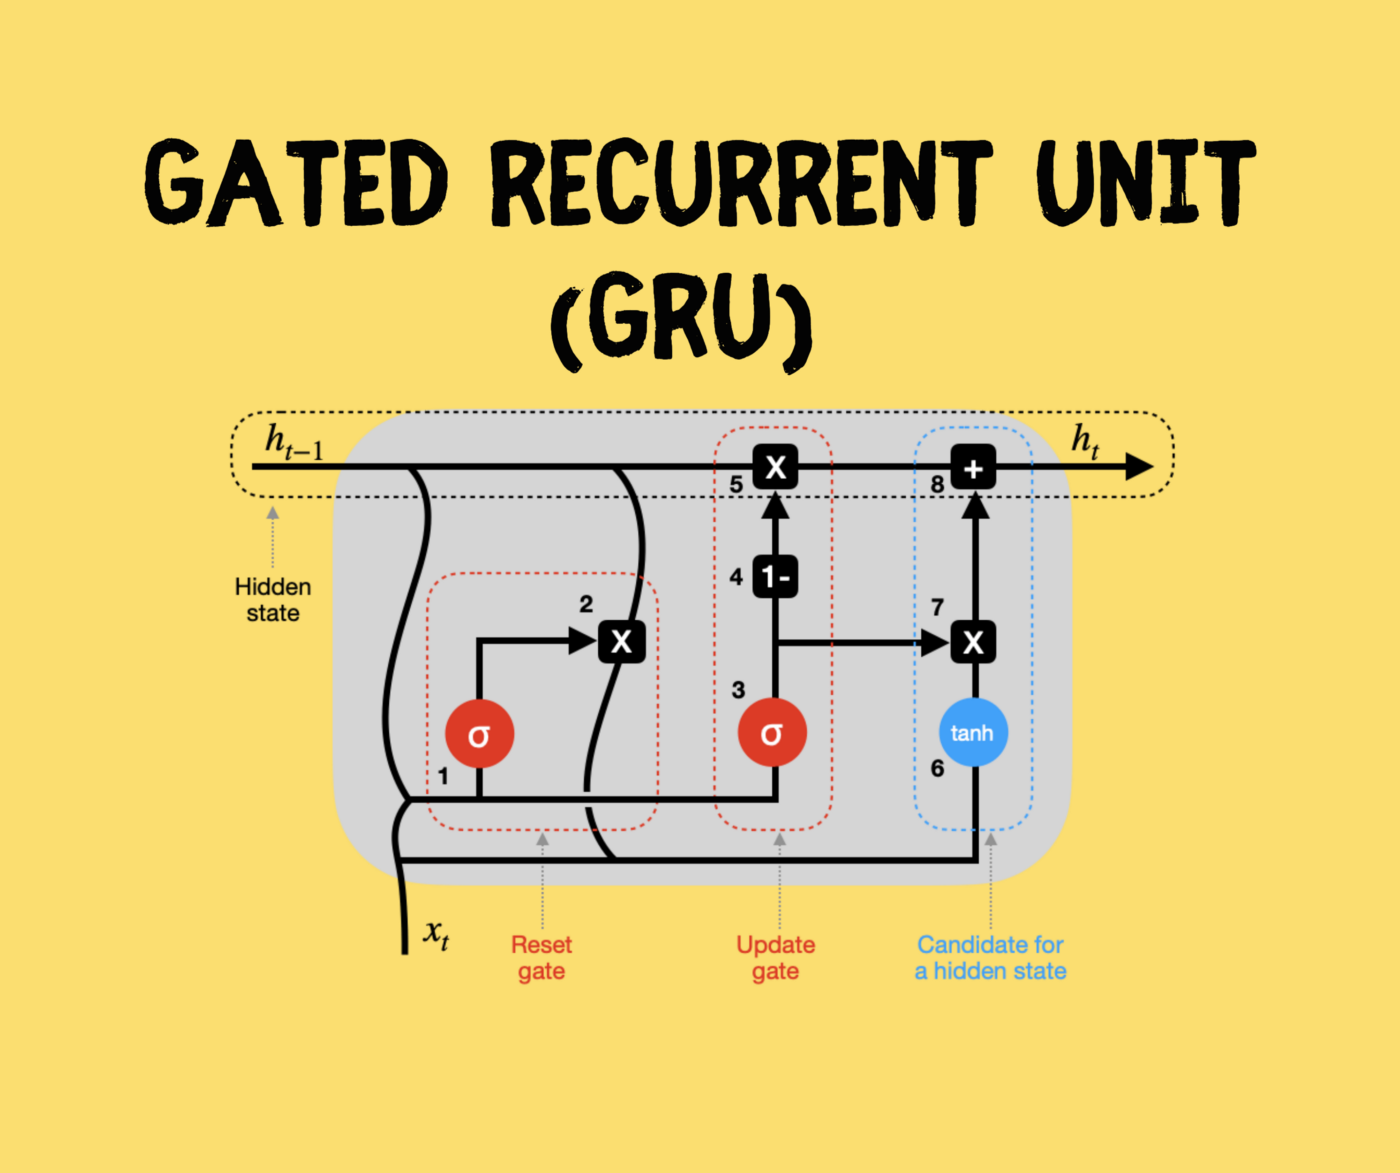

In [46]:
torch.manual_seed(42)
torch.backends.cuda.deterministic = True

<a id='Short_Explanation_what_is_nn_Embedding'></a>
## Short Explanation what is nn.Embedding

Assume we want to build our own Word Embeddings. How can we do it ?

1. Tokenize text - Split it into separate entities (word and symbols)
2. Build Vocabulary (recall Bag of Words). So now we can assign to each word some int (long) number
3. Construct some random matrix with next dimension vocab_size X embedding_dimension
4. Now for each word we can take particular vector from builded matrix

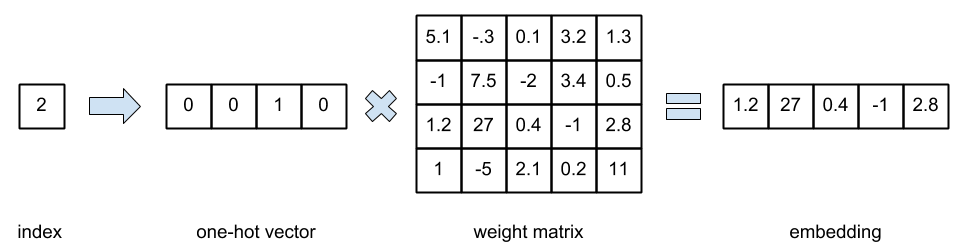

Here is the full pipeline

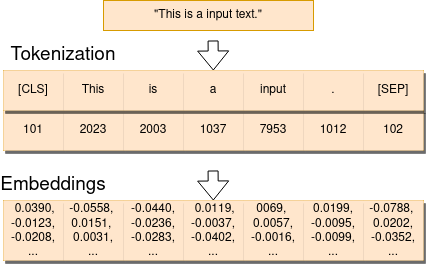

This matrix is a trainable parameter matrix and will be oprimized while training

TODO: read about special tokens : `<CLS>`, `<SEP>`

In [47]:
# Lets build or RNN Class 

class UniversalRNN(nn.Module):
    
    def __init__(
        self,
        num_embeddings,
        out_channels,
        rnn_channels=512,
        rnn_type=nn.GRU,
        n_rnns=1,
        bidirectional=True,
        average_type=None
    ):
        super().__init__()
        
        self.embedding_layer = nn.Embedding(num_embeddings, rnn_channels)
        # TODO: What is bidirectional ? Try unidirectional
        self.rnns = rnn_type(
            rnn_channels, 
            rnn_channels, 
            bidirectional=bidirectional, 
            num_layers=n_rnns,
            batch_first=True
        )
        if not (average_type is None or average_type in ["mean", "last"]):
            raise ValueError(f"{average_type} is nit supported average_type")
        self.average_type = average_type
        self.classifier = nn.Linear(
            rnn_channels * 2 if bidirectional else rnn_channels, 
            out_channels, 
        )
        
    def forward(self, x):
        x = self.embedding_layer(x)
        x = self.rnns(x)[0]
        if self.average_type is None:
            x = self.classifier(x)
        else:
            # Dimension reminder : [Batch, Time Dimension, Channels]
            if self.average_type == "mean":
                x = x.mean(1)
            elif self.average_type == "last":
                x = x[:,-1,:]
            x = self.classifier(x)
        return x
        
        

In [48]:
nn_model = UniversalRNN(128, 2)
nn_model

UniversalRNN(
  (embedding_layer): Embedding(128, 512)
  (rnns): GRU(512, 512, batch_first=True, bidirectional=True)
  (classifier): Linear(in_features=1024, out_features=2, bias=True)
)

<a id='Sentance_and_Token_Classification'></a>
# Sentance and Token Classification

## Sentence Classification

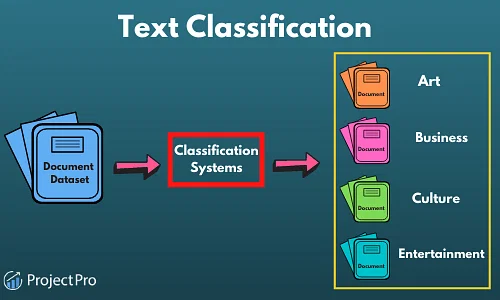

## Token Classification

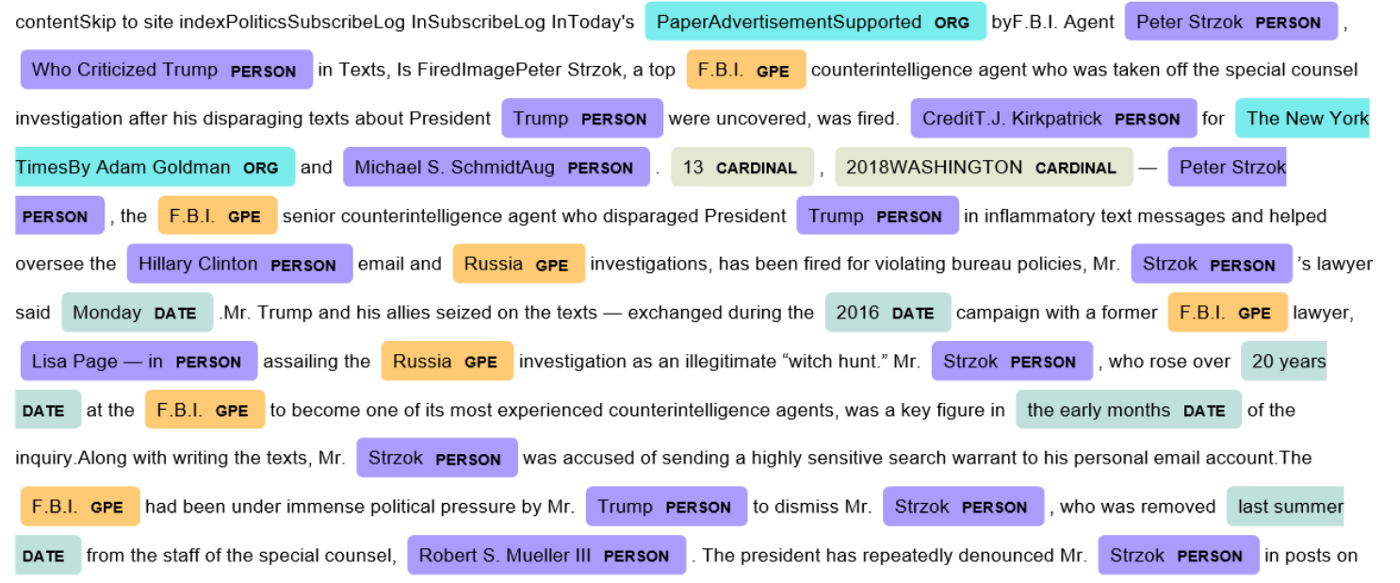

In [49]:
nn_model = UniversalRNN(128, 2)
nn_model

UniversalRNN(
  (embedding_layer): Embedding(128, 512)
  (rnns): GRU(512, 512, batch_first=True, bidirectional=True)
  (classifier): Linear(in_features=1024, out_features=2, bias=True)
)

In [50]:
# Shape: Batch size, Time Dimension 
random_input = torch.randint(low=0, high=128, size=(2, 128))
random_input.shape

torch.Size([2, 128])

In [51]:
# Token Classification Example
nn_model(random_input).shape

torch.Size([2, 128, 2])

In [52]:
nn_model = UniversalRNN(128, 2, average_type="mean")
nn_model

UniversalRNN(
  (embedding_layer): Embedding(128, 512)
  (rnns): GRU(512, 512, batch_first=True, bidirectional=True)
  (classifier): Linear(in_features=1024, out_features=2, bias=True)
)

In [53]:
# Text Classification Example
nn_model(random_input).shape

torch.Size([2, 2])

## Go Deeper in [PyTorch](https://pytorch.org/docs/stable/index.html)

### [Pytorch Dataset and Dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html) + [torchtext](https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html)

In [54]:
# Select Tokenization algorithm: check Short_Explanation_what_is_nn_Embedding step 1
tokenizer = get_tokenizer('basic_english')

def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

# Build Vocabulary: check Short_Explanation_what_is_nn_Embedding step 2
vocab = build_vocab_from_iterator(
    yield_tokens(train["light_clean_comment_text"]), 
    specials=["<unk>"]
)
vocab.set_default_index(vocab["<unk>"])

In [55]:
vocab.lookup_indices(["fucking"])

[387]

In [56]:
vocab.lookup_tokens([387])

['fucking']

In [57]:
# TODO: Read More - https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset
class TextDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        texts,
        targets,
        dataset_vocab,
        dataset_tokenizer,
        max_length,
        trim_policy="random"
    ):
        self.targets = targets
        self.texts = texts
        self.vocab = dataset_vocab
        self.tokenizer = dataset_tokenizer
        
        self.max_length = max_length
        if trim_policy not in ["random", "first"]:
            raise ValueError(f"{trim_policy} is not valid trim_policy")
        self.trim_policy = trim_policy
        
    # TODO: Is it a best solution? Read about collate_fn - https://pytorch.org/docs/stable/data.html
    def select_text_subsequance(self, input):
        if len(input) < self.max_length:
            return input + [0] * (self.max_length - len(input))
        elif len(input) > self.max_length:
            if self.trim_policy == "random":
                start = np.random.randint(0, len(input) - self.max_length)
            elif self.trim_policy == "first":
                start = 0
            return input[start : start + self.max_length]
        else: 
            return input
        
    def __getitem__(self, idx):
        text_ids = self.vocab(self.tokenizer(self.texts[idx]))
        # In order to form batch, which is a tensor - we have to get sequnces of same length
        text_ids = self.select_text_subsequance(text_ids)
        return (
            torch.LongTensor(text_ids), 
            torch.from_numpy(self.targets[idx]).float()
        )
    
    def __len__(self):
        return len(self.texts)

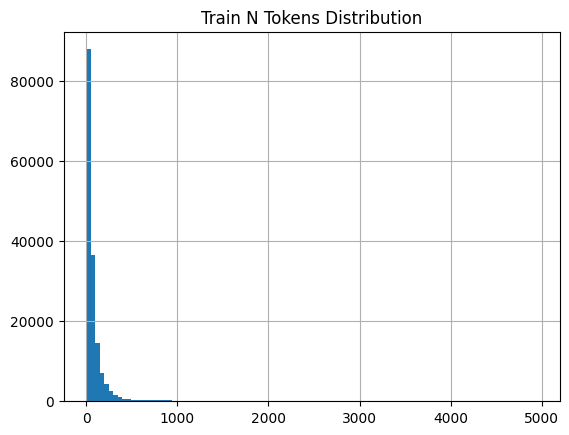

0.95 Quantile of N tokens: 266.5


In [58]:
# Here we want to figure out empirically max_length
# TODO: Try to propose another ways to do it 

train_n_tokens = train["light_clean_comment_text"].apply(lambda x : len(tokenizer(x)))

plt.title("Train N Tokens Distribution")
train_n_tokens.hist(bins=100)
plt.show()

print(f"0.95 Quantile of N tokens: {np.quantile(train_n_tokens, 0.95)}")

In [59]:
train_torch_dataset = TextDataset(
    texts=train["light_clean_comment_text"].to_list(),
    targets=train[TARGET_COLUMNS].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=300,
    # trim_policy="first"
)

In [60]:
doc_idx = 10

doc_ids, doc_target = train_torch_dataset[doc_idx]
print(
    f"Text: {train_torch_dataset.texts[doc_idx]}\n"
    f"Text Ids: {doc_ids}\n"
    f"Target: {doc_target}\n"
    f"Text Ids length: {len(doc_ids)}"
)

Text: ". Fair use rationale for Image:Wonju.jpg. Thanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but there is no explanation or rationale as to why its use in Wikipedia articles constitutes fair use. In addition to the boilerplate fair use template, you must also write out on the image description page a specific explanation or rationale for why using this image in each article is consistent with fair use. Please go to the image description page and edit it to include a fair use rationale. If you have uploaded other fair use media, consider checking that you have specified the fair use rationale on those pages too. You can find a list of 'image' pages you have edited by clicking on the ""my contributions"" link (it is located at the very top of any Wikipedia page when you are logged in), and then selecting ""Image"" from the dropdown box. Note that any fair use images uploaded after 4 May, 2006, and lacking such an exp

In [61]:
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=16,
    shuffle=True,
    drop_last=True,
    num_workers=8,
    pin_memory=True
)

for batch in train_torch_dataloader:
    break
    
print(
    f"`Text` batch:\n{batch[0]}\n"
    f"`Target` batch:\n{batch[1]}"
)

`Text` batch:
tensor([[  139,     8,    25,  ...,     0,     0,     0],
        [   93,    22,   147,  ...,   263,   123,     1],
        [79286,     1,  2323,  ...,     0,     0,     0],
        ...,
        [   54,   181,    99,  ...,     0,     0,     0],
        [  313,    16,  1870,  ...,     0,     0,     0],
        [    5,   907,    13,  ...,     0,     0,     0]])
`Target` batch:
tensor([[0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.]])


### PyTorch Train and Validation loop 

In [62]:
def torch_loop(
    dataloader, 
    inp_model,
    inp_optimizer,
    inp_criterion,
    mode="train",
    device="cpu"
):
    # TODO: Read about train and eval modes on official Torch Docs. What do they change ?
    if mode == "train":
        inp_model.train()
    else:
        inp_model.eval()
    all_predicted_label = []
    all_losses = []
    all_targets = []
    # We need this context in order to control gradient computation
    # mode == True - gradient will NOT be computed, mode == False - gradient will be computed
    with torch.inference_mode(mode=(mode != "train")):
        for text, label in tqdm(dataloader):
            text, label = text.to(device), label.to(device)
            if mode == "train":
                inp_optimizer.zero_grad()
            # 1.1 Compute Forward path
            predicted_label = inp_model(text)
            # 1.2 Compute Cost function (part of Forward path)
            loss = criterion(predicted_label, label)
            if mode == "train":
                # TODO: Is mean a best choice ?
                # 2. Compute Backward path
                loss.mean().backward()
                # TODO: Try gradient clipping 
                # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
                # 3. Apply gradient descent `on steroids` 
                optimizer.step()
                
            # Accumulate stats
            # We receive logits and we have to transform them into `probs`. That is why sigmoid is used
            all_predicted_label.append(torch.sigmoid(predicted_label.detach()).cpu().numpy())
            all_losses.append(loss.detach().cpu().numpy())
            all_targets.append(label.detach().cpu().numpy())
    all_predicted_label = np.concatenate(all_predicted_label)
    all_losses = np.concatenate(all_losses)
    all_targets = np.concatenate(all_targets)
    
    return all_predicted_label, all_losses, all_targets

def print_losses(input):
    for cls_idx, cls_name in enumerate(TARGET_COLUMNS):
        print(f"{tgt_col} BCE loss: {input[:,cls_idx].mean()}")
    print(f"Result BCE loss: {input.mean()}")

In [63]:
nn_model = UniversalRNN(
    num_embeddings=len(vocab),
    out_channels=len(TARGET_COLUMNS),
    average_type="mean"
).to("cuda")

# TODO: Read more about different loss funcrions https://pytorch.org/docs/stable/nn.html#loss-functions
criterion = torch.nn.BCEWithLogitsLoss(reduction="none")
# TODO: Read more about Optimizers https://pytorch.org/docs/stable/optim.html
# TODO: Try to tune hyperparameters here
optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)
# TODO: Read more about schedulers https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=1, factor=0.5, min_lr=1e-7, mode="max", verbose=True)

In [64]:
train_torch_dataset = TextDataset(
    texts=train.iloc[folds_train_test_ids[0][0]]["light_clean_comment_text"].to_list(),
    targets=train.iloc[folds_train_test_ids[0][0]][TARGET_COLUMNS].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=300,
)
# TODO: Read more about DataLoader : https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
train_torch_dataloader = torch.utils.data.DataLoader(
    train_torch_dataset,
    batch_size=32,
    # It is highly important to shuffle data while training. Why ?
    shuffle=True,
    # It is important to drop last batch while training. Why ?
    drop_last=True,
    num_workers=8,
    pin_memory=True
)

valid_torch_dataset = TextDataset(
    texts=train.iloc[folds_train_test_ids[0][1]]["light_clean_comment_text"].to_list(),
    targets=train.iloc[folds_train_test_ids[0][1]][TARGET_COLUMNS].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=300,
    trim_policy="first"
)
valid_torch_dataloader = torch.utils.data.DataLoader(
    valid_torch_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True
)

In [65]:
# TODO: read this article about sample, batch, epoch differences - https://machinelearningmastery.com/difference-between-a-batch-and-an-epoch/
# TODO: Try to train longer 
n_epochs = 3

train_all_epoch_labels = []
train_all_epoch_losses = []
train_all_epoch_targets = []
valid_all_epoch_labels = []
valid_all_epoch_losses = []
valid_all_epoch_targets = []
valid_roc_aucs = []
train_roc_aucs = []

best_metric = - np.inf
best_model_state_dict = None

for epoch in range(1, n_epochs + 1):
    print(f"Starting Epoch {epoch}")
    # 1.1 Iterate over all train dataset and update model weights
    print("Train phase")
    train_epoch_labels, train_epoch_losses, train_epoch_targets = torch_loop(
        dataloader=train_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device="cuda",
        mode="train"
    )
    # 1.2 Compute and print train metrics
    print("Train metrics")
    _, train_roc_auc = comp_metric(
        train_epoch_targets, 
        train_epoch_labels
    )
    print("Train BCE losses")
    print_losses(train_epoch_losses)
    # 2.1 Iterate over all valid dataset and compute predictions
    print("Valid phase")
    valid_epoch_labels, valid_epoch_losses, valid_epoch_targets = torch_loop(
        dataloader=valid_torch_dataloader, 
        inp_model=nn_model,
        inp_optimizer=optimizer,
        inp_criterion=criterion,
        device="cuda",
        mode="eval"
    )
    # 2.2 Compute and print valid metrics
    print("Valid metrics")
    _, valid_roc_auc = comp_metric(
        valid_epoch_targets, 
        valid_epoch_labels
    )
    print("Valid BCE losses")
    print_losses(valid_epoch_losses)
    # 3. Update learning rate (if needed)
    scheduler.step(valid_roc_auc)
    # 4. Save best model
    if valid_roc_auc > best_metric:
        best_metric = valid_roc_auc
        best_model_state_dict = deepcopy(nn_model.state_dict())
    # 5. Accumulate all stats  
    train_all_epoch_labels.append(train_epoch_labels)
    train_all_epoch_losses.append(train_epoch_losses)
    train_all_epoch_targets.append(train_epoch_targets)
    valid_all_epoch_labels.append(valid_epoch_labels)
    valid_all_epoch_losses.append(valid_epoch_losses)
    valid_all_epoch_targets.append(valid_epoch_targets)
    valid_roc_aucs.append(valid_roc_auc)
    train_roc_aucs.append(train_roc_auc)
    
        

Starting Epoch 1
Train phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3989/3989 [03:09<00:00, 21.02it/s]


Train metrics
toxic Roc Auc: 0.9528393056855488
severe_toxic Roc Auc: 0.9778591558365723
obscene Roc Auc: 0.9743305546988249
threat Roc Auc: 0.9310386450262753
insult Roc Auc: 0.968208516105448
identity_hate Roc Auc: 0.941261827432835
Result Roc Auc: 0.9575896674642507
Train BCE losses
identity_hate BCE loss: 0.1309475302696228
identity_hate BCE loss: 0.028643550351262093
identity_hate BCE loss: 0.06980626285076141
identity_hate BCE loss: 0.014533963985741138
identity_hate BCE loss: 0.08179224282503128
identity_hate BCE loss: 0.03270118683576584
Result BCE loss: 0.059737470000982285
Valid phase


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 998/998 [00:14<00:00, 69.26it/s]


Valid metrics
toxic Roc Auc: 0.9752551203287566
severe_toxic Roc Auc: 0.9895732010043731
obscene Roc Auc: 0.9874492587643953
threat Roc Auc: 0.9780442621323895
insult Roc Auc: 0.9821995976111783
identity_hate Roc Auc: 0.9717606826339225
Result Roc Auc: 0.9807136870791692
Valid BCE losses
identity_hate BCE loss: 0.10110697895288467
identity_hate BCE loss: 0.024235518649220467
identity_hate BCE loss: 0.055314116179943085
identity_hate BCE loss: 0.013350888155400753
identity_hate BCE loss: 0.06961482763290405
identity_hate BCE loss: 0.026331333443522453
Result BCE loss: 0.04832560941576958
Starting Epoch 2
Train phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3989/3989 [03:21<00:00, 19.83it/s]


Train metrics
toxic Roc Auc: 0.9851569777379807
severe_toxic Roc Auc: 0.9902625243012941
obscene Roc Auc: 0.9925308242997436
threat Roc Auc: 0.9834941974143917
insult Roc Auc: 0.9886722956137346
identity_hate Roc Auc: 0.9835141390793671
Result Roc Auc: 0.9872718264077519
Train BCE losses
identity_hate BCE loss: 0.08087816089391708
identity_hate BCE loss: 0.022488746792078018
identity_hate BCE loss: 0.04470816254615784
identity_hate BCE loss: 0.009551038965582848
identity_hate BCE loss: 0.056358225643634796
identity_hate BCE loss: 0.022269247099757195
Result BCE loss: 0.03937559574842453
Valid phase


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 998/998 [00:13<00:00, 73.28it/s]


Valid metrics
toxic Roc Auc: 0.976375862768383
severe_toxic Roc Auc: 0.9899677789458687
obscene Roc Auc: 0.9884262508503775
threat Roc Auc: 0.9806248966224487
insult Roc Auc: 0.9830358578448536
identity_hate Roc Auc: 0.9733329028644788
Result Roc Auc: 0.9819605916494017
Valid BCE losses
identity_hate BCE loss: 0.10479048639535904
identity_hate BCE loss: 0.024804294109344482
identity_hate BCE loss: 0.05711406469345093
identity_hate BCE loss: 0.01080284547060728
identity_hate BCE loss: 0.06841614097356796
identity_hate BCE loss: 0.030650831758975983
Result BCE loss: 0.04942978173494339
Starting Epoch 3
Train phase


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3989/3989 [03:24<00:00, 19.52it/s]


Train metrics
toxic Roc Auc: 0.9943639822030712
severe_toxic Roc Auc: 0.9932647164409957
obscene Roc Auc: 0.996584930019001
threat Roc Auc: 0.9941335173753416
insult Roc Auc: 0.9936812095917433
identity_hate Roc Auc: 0.9935529795620764
Result Roc Auc: 0.9942635558653715
Train BCE losses
identity_hate BCE loss: 0.05291210487484932
identity_hate BCE loss: 0.019269578158855438
identity_hate BCE loss: 0.032864440232515335
identity_hate BCE loss: 0.00645375344902277
identity_hate BCE loss: 0.04360376298427582
identity_hate BCE loss: 0.015354469418525696
Result BCE loss: 0.02840968780219555
Valid phase


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 998/998 [00:13<00:00, 75.59it/s]

Valid metrics
toxic Roc Auc: 0.9713935246138392
severe_toxic Roc Auc: 0.987939626499287
obscene Roc Auc: 0.98630699732284
threat Roc Auc: 0.9821800258030369
insult Roc Auc: 0.9792774743428204
identity_hate Roc Auc: 0.9699835412923886
Result Roc Auc: 0.9795135316457021
Valid BCE losses
identity_hate BCE loss: 0.12291999161243439
identity_hate BCE loss: 0.02501576580107212
identity_hate BCE loss: 0.058719709515571594
identity_hate BCE loss: 0.010889838449656963
identity_hate BCE loss: 0.07774895429611206
identity_hate BCE loss: 0.028427887707948685
Result BCE loss: 0.053953688591718674


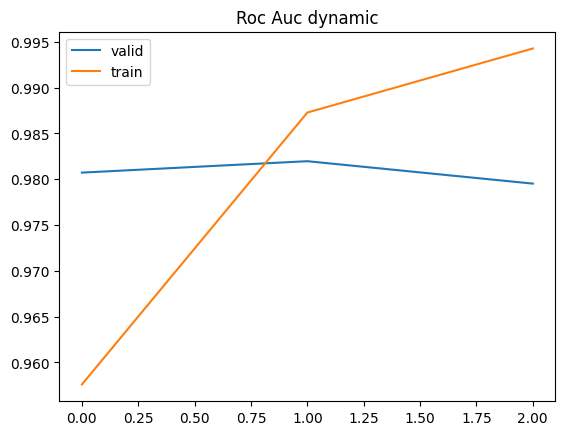

In [66]:
plt.title("Roc Auc dynamic")
plt.plot(valid_roc_aucs, label="valid")
plt.plot(train_roc_aucs, label="train")
plt.legend()
plt.show()

In [67]:
# Load best model
nn_model.load_state_dict(best_model_state_dict)

test_torch_dataset = TextDataset(
    texts=test["light_clean_comment_text"].to_list(),
    targets=test[TARGET_COLUMNS].values,
    dataset_vocab=vocab,
    dataset_tokenizer=tokenizer,
    max_length=300,
    trim_policy="first"
)
test_torch_dataloader = torch.utils.data.DataLoader(
    test_torch_dataset,
    batch_size=32,
    shuffle=False,
    drop_last=False,
    num_workers=8,
    pin_memory=True
)

test_labels, test_losses, test_targets = torch_loop(
    dataloader=test_torch_dataloader, 
    inp_model=nn_model,
    inp_optimizer=optimizer,
    inp_criterion=criterion,
    device="cuda",
    mode="eval"
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 67.55it/s]


In [68]:
print("Test metrics")
comp_metric(
    test_targets, 
    test_labels
);
print("Test BCE losses")
print_losses(test_losses)

Test metrics
toxic Roc Auc: 0.9612658150362946
severe_toxic Roc Auc: 0.9869999820520133
obscene Roc Auc: 0.9725666086778435
threat Roc Auc: 0.9820707601288666
insult Roc Auc: 0.9704734597165008
identity_hate Roc Auc: 0.9694082693297464
Result Roc Auc: 0.9737974824902108
Test BCE losses
identity_hate BCE loss: 0.1881895512342453
identity_hate BCE loss: 0.024768147617578506
identity_hate BCE loss: 0.11782252788543701
identity_hate BCE loss: 0.011688591912388802
identity_hate BCE loss: 0.09378655254840851
identity_hate BCE loss: 0.03735172003507614
Result BCE loss: 0.07893452048301697


## Comparing Reccurent Nets to Bag of Words + Regression

**Pros**
+ Shows better performance in terms of metrics
+ Take into account context 
+ Requires less text preprocessing

**Cons**
- Harder to implement
- Harder to deploy
- Requires GPU, at least for training
- Requires more powerfull clusters for inference
- Works longer
- Lacks interpretability

<a id='Homework'></a>
# Homework

Thoery:
- Take a look at all links 
- Read and analyze all theory `TODO`s

Practice:
- Do all practical `TODO`s
- Try to tune hyperparameters and text preprocessing for all 3 approaches
- Implement Cross Validation for RNNs
- Plot dynamic plots for stats accumulated while RNN training
- Check `classification_report` in `workshop` and apply it here. Explore models' mistakes deeper
- Try this notebook with other datasets:
    - https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/code?datasetId=572515
    - ../data/propaganda_detection_our_data/
    - https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data
- Search Kaggle or other resources for interesting dataset and try to apply previous algorithmes 

Advanced practice:
- Take Word2Vec or Flair word embeddings and use them instead of torch.nn.Embedding. Compare results